# Model training

In [1]:
import os
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_train = pd.read_csv('../input/feedback-prize-effectiveness/train.csv')

### Reproducibility

In [3]:
seed = 33

os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

def set_global_determinism(seed=seed, fast_n_close=False):
    """
        Enable 100% reproducibility on operations related to tensor and randomness.
        Parameters:
        seed (int): seed value for global randomness
        fast_n_close (bool): whether to achieve efficient at the cost of determinism/reproducibility
    """
    set_seeds(seed=seed)
    if fast_n_close:
        return

    logging.warning("*******************************************************************************")
    logging.warning("*** set_global_determinism is called,setting full determinism, will be slow ***")
    logging.warning("*******************************************************************************")

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    # https://www.tensorflow.org/api_docs/python/tf/config/threading/set_inter_op_parallelism_threads
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
    from tfdeterminism import patch
    patch()

## Training

In [4]:
config = {
    'submit': True,
    'n_samples': 0,
#     'test_size': 0.1,
    'test_size': 0.0,
    'val_size': 0.1,
    'MAX_LEN': 512,
    'batch_size': 12,
}
checkpoint_filepath = '/model'

### Sets

In [5]:
from transformers import TFBertModel
import transformers

def bert_encode(texts, tokenizer, max_len=config['MAX_LEN']):
    input_ids = []
    token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(text, max_length=max_len, truncation=True, padding='max_length',
                         add_special_tokens=True)
        input_ids.append(token['input_ids'])
        token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(token_type_ids), np.array(attention_mask)

In [6]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('../input/huggingface-bert-variants/bert-base-cased/bert-base-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

## Data preparation

In [7]:
sep = tokenizer.sep_token
cls = tokenizer.cls_token

def preprocess(df_train, n_samples = 0):
    if n_samples != 0:
        df_train = df_train.sample(n=n_samples, random_state = seed)
    
    # Label encoding
    new_label = {"discourse_effectiveness": {"Ineffective": 0, "Adequate": 1, "Effective": 2}}
    df_train = df_train.replace(new_label)
    df_train = df_train.rename(columns = {"discourse_effectiveness": "label"})
    # One-hot encode and set columns in order
#     y = pd.get_dummies(df_train['discourse_effectiveness'])
#     y = y[['Ineffective','Adequate','Effective']]

#     sep = tokenizer.sep_token
    df_train['input'] = cls + df_train.discourse_type + sep + df_train.discourse_text

    X = df_train['input']
    y = df_train['label']
    
    return X, y

In [8]:
from sklearn.model_selection import train_test_split

def data_split(X, y, test_size, val_size):
    if config['test_size'] != 0:
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = test_size, random_state = seed, stratify=y)
        X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size = val_size, random_state = seed, stratify=y_train)
        
        X_train = bert_encode(X_train.astype(str), tokenizer)
        X_val = bert_encode(X_val.astype(str), tokenizer)
        X_test = bert_encode(X_test.astype(str), tokenizer)

        y_train = y_train.values
        y_val = y_val.values
        y_test = y_test.values
        
        return X_train, y_train, X_val, y_val, X_test, y_test
    else:
        X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = val_size, random_state = seed, stratify=y)
        X_train = bert_encode(X_train.astype(str), tokenizer)
        X_val = bert_encode(X_val.astype(str), tokenizer)

        y_train = y_train.values
        y_val = y_val.values
        
        return X_train, y_train, X_val, y_val, None, None

In [9]:
X, y = preprocess(df_train, n_samples = 0)
X_train, y_train, X_val, y_val, X_test, y_test = data_split(X, y, test_size = config['test_size'], val_size = config['val_size'])

In [10]:
unique, counts = np.unique(y_train, return_counts=True)
counts = counts / y_train.size
# train = dict(zip(unique, counts))
print(f"y_train size: {y_train.shape}, label distribution: {dict(zip(unique, counts))}")

unique, counts = np.unique(y_val, return_counts=True)
counts = counts / y_val.size
# val = dict(zip(unique, counts))
print(f"y_val size: {y_val.shape}, label distribution: {dict(zip(unique, counts))}")

if config['test_size'] != 0:
    unique, counts = np.unique(y_test, return_counts=True)
    counts = counts / y_test.size
    # test = dict(zip(unique, counts))
    print(f"y_test size: {y_test.shape}, label distribution: {dict(zip(unique, counts))}")

y_train size: (33088,), label distribution: {0: 0.17577369439071566, 1: 0.5705693907156673, 2: 0.253656914893617}
y_val size: (3677,), label distribution: {0: 0.17568670111503942, 1: 0.5705738373674191, 2: 0.25373946151754145}


In [11]:
AUTO = tf.data.experimental.AUTOTUNE

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(32768, seed = seed)
    .batch(config['batch_size'])
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .batch(config['batch_size'])
    .cache()
    .prefetch(AUTO)
)

2022-06-16 17:08:08.608859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 17:08:08.610467: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 17:08:08.611589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 17:08:08.616900: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Model

In [12]:
def get_callbacks(patience):
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      min_delta=0,
                                                      patience=patience,
                                                      verbose=0,
                                                      mode='min',
                                                      baseline=None,
                                                      restore_best_weights=True)
    
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True)
    
    return [early_stopping, model_checkpoint_callback]

In [13]:
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model

input_ids = Input(shape=(config['MAX_LEN'],), dtype=tf.int32, name="input_ids")
token_type_ids = Input(shape=(config['MAX_LEN'],), dtype=tf.int32, name="token_type_ids")
attention_mask = Input(shape=(config['MAX_LEN'],), dtype=tf.int32, name="attention_mask")

# Bert
bert_model = (TFBertModel.from_pretrained('../input/huggingface-bert-variants/bert-base-cased/bert-base-cased'))
sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

clf_output = sequence_output[:, 0, :]
clf_output = Dropout(0.1)(clf_output)
# clf_output = Dense(256, activation='softmax')(clf_output)
out = Dense(3, activation='softmax')(clf_output)
    
model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)

Some layers from the model checkpoint at ../input/huggingface-bert-variants/bert-base-cased/bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at ../input/huggingface-bert-variants/bert-base-cased/bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [14]:
initial_learning_rate = 2e-5
epochs = 56
steps_per_epoch = 200
needed_steps = int(np.ceil(y_train.shape[0]/config['batch_size']))
need_steps_for_epochs = needed_steps / steps_per_epoch
# epochs = 28
warmup_proportion = 0.1

patience = 40
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(0.1 * num_train_steps)

In [15]:
print(f"Steps needed for all training data: {needed_steps}, that's epochs {need_steps_for_epochs}")

Steps needed for all training data: 2758, that's epochs 13.79


### Optimizer

In [16]:
import tensorflow_addons as tfa

optimizer = tfa.optimizers.RectifiedAdam(learning_rate=initial_learning_rate,
                                         total_steps=num_train_steps,
                                         warmup_proportion=warmup_proportion,
                                         min_lr=0,
                                         weight_decay = 0.01,
                                         beta_1 = 0.9,
                                         beta_2 = 0.99
                                        )

In [17]:
model.compile(optimizer, 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [18]:
model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 512)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 108310272   input_ids[0][0]                  
                                                                 attention_mask[0][0]         

### Training

In [19]:
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_dataset,
#     batch_size = config['batch_size'],
    epochs=epochs,
    callbacks=get_callbacks(patience=7)
)

Epoch 1/56


2022-06-16 17:09:20.855058: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


200/200 [==============================] - 346s 1s/step - loss: 1.0280 - accuracy: 0.5183 - val_loss: 0.8858 - val_accuracy: 0.6111
Epoch 2/56
200/200 [==============================] - 275s 1s/step - loss: 0.8715 - accuracy: 0.6125 - val_loss: 0.7912 - val_accuracy: 0.6448
Epoch 3/56
200/200 [==============================] - 275s 1s/step - loss: 0.8169 - accuracy: 0.6317 - val_loss: 0.7789 - val_accuracy: 0.6538
Epoch 4/56
200/200 [==============================] - 274s 1s/step - loss: 0.7745 - accuracy: 0.6538 - val_loss: 0.7501 - val_accuracy: 0.6649
Epoch 5/56
200/200 [==============================] - 274s 1s/step - loss: 0.7881 - accuracy: 0.6413 - val_loss: 0.7674 - val_accuracy: 0.6579
Epoch 6/56
200/200 [==============================] - 274s 1s/step - loss: 0.7683 - accuracy: 0.6475 - val_loss: 0.7497 - val_accuracy: 0.6592
Epoch 7/56
200/200 [==============================] - 274s 1s/step - loss: 0.7390 - accuracy: 0.6687 - val_loss: 0.7445 - val_accuracy: 0.6696
Epoch 8/56

In [20]:
if config['test_size'] != 0:
    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices((X_test, y_test))
        .batch(config['batch_size'])
        .cache()
        .prefetch(AUTO)
    )
    
    model.evaluate(test_dataset)

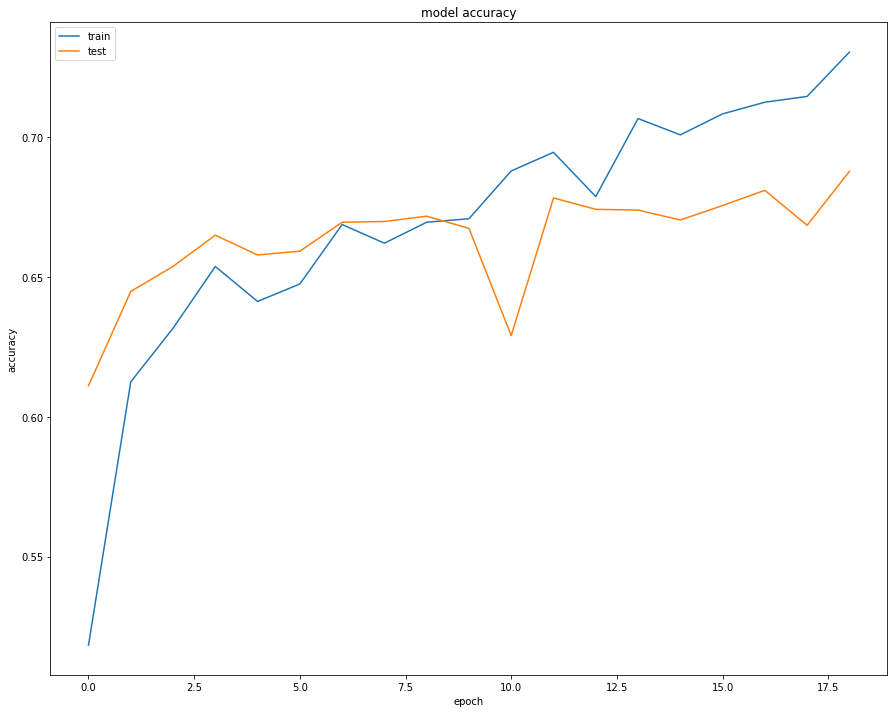

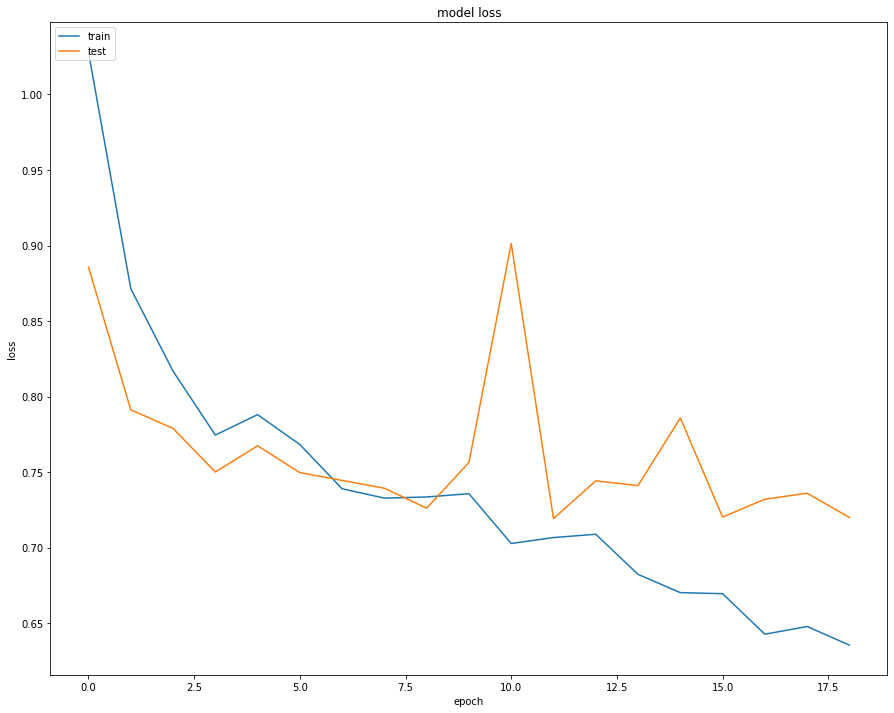

In [21]:
figsize = (15, 12)

plt.figure(figsize=figsize)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=figsize)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Load best model

In [22]:
model.load_weights(checkpoint_filepath)

## Submission

In [23]:
df_test = pd.read_csv('../input/feedback-prize-effectiveness/test.csv')
df_test.head()

,discourse_id,essay_id,discourse_text,discourse_type
0,a261b6e14276,D72CB1C11673,Making choices in life can be very difficult. ...,Lead
1,5a88900e7dc1,D72CB1C11673,Seeking multiple opinions can help a person ma...,Position
2,9790d835736b,D72CB1C11673,it can decrease stress levels,Claim
3,75ce6d68b67b,D72CB1C11673,a great chance to learn something new,Claim
4,93578d946723,D72CB1C11673,can be very helpful and beneficial.,Claim


In [24]:
pd.read_csv('../input/feedback-prize-effectiveness/sample_submission.csv').head()

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.20,0.60,0.40
1,5a88900e7dc1,3.00,6.00,1.00
2,9790d835736b,1.00,2.00,3.00
3,75ce6d68b67b,0.33,0.34,0.33
4,93578d946723,0.01,0.24,0.47


In [25]:
df_test['input'] = cls + df_test.discourse_type + sep + df_test.discourse_text
X_pred = bert_encode(df_test.input.astype(str), tokenizer)

In [26]:
y_pred = model.predict(X_pred, verbose=1)
y_pred

1/1 [==============================] - 3s 3s/step


array([[0.00654476, 0.22641009, 0.76704514],
       [0.02099188, 0.5043525 , 0.47465563],
       [0.01891932, 0.5221147 , 0.45896602],
       [0.12337936, 0.6091586 , 0.26746204],
       [0.02019818, 0.39176166, 0.5880402 ],
       [0.00689349, 0.12945876, 0.86364776],
       [0.00474171, 0.10602302, 0.88923526],
       [0.01272075, 0.34331217, 0.64396703],
       [0.03188467, 0.3101491 , 0.65796614],
       [0.01656292, 0.5475502 , 0.43588686]], dtype=float32)

In [27]:
df_test['Ineffective'] = y_pred[:,0]
df_test['Adequate'] = y_pred[:,1]
df_test['Effective'] = y_pred[:,2]
df_test.drop(['essay_id','discourse_text','discourse_type', 'input'], axis=1, inplace=True)

In [28]:
df_test.head()

,discourse_id,Ineffective,Adequate,Effective
0,a261b6e14276,0.006545,0.226410,0.767045
1,5a88900e7dc1,0.020992,0.504353,0.474656
2,9790d835736b,0.018919,0.522115,0.458966
3,75ce6d68b67b,0.123379,0.609159,0.267462
4,93578d946723,0.020198,0.391762,0.588040


In [29]:
df_test.to_csv("submission.csv", index=False)